# Prepare the classfier

## Define paths

In [2]:
from __future__ import print_function
import numpy as np
from keras import layers
from keras import models
from keras import optimizers
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import matplotlib.pyplot as plt
import os

def plot_history(history, model_name):

    # define input data
    hist_dict = history.history
    indicators = ("acc", "loss")

    # create figure
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))
    colors = ["#454545", "#007ca5", "#A91458"]

    x = np.arange(1, len(hist_dict["acc"])+1)

    # accuracy
    ax = axes[0]
    ax.plot(x, hist_dict["acc"], marker="o", c=colors[0], label="Acc")
    ax.plot(x, hist_dict["val_acc"], ls="--", c=colors[1], label="Val Acc")
    ax.set_title("%s Accuracy" % model_name)
    ax.set_xlabel("Epochs")
    ax.legend(loc="lower right")
    
    # plot bar
    y_a, y_b = ax.get_ylim()
    bar = np.array(hist_dict["val_acc"]).argmax() + 1 
    ax.plot([bar, bar], [y_a, y_b], c="#505050", zorder=0, lw=0.5)
    ax.set_ylim((y_a, y_b))

    # loss
    ax = axes[1]
    ax.plot(x, hist_dict["loss"], marker="o", c=colors[0], label="Loss")
    ax.plot(x, hist_dict["val_loss"], ls="--", c=colors[1], label="Val Loss")
    ax.set_title("%s Loss" % model_name)
    ax.set_xlabel("Epochs")
    ax.legend(loc="lower right")
    #bar = hist_dict["val_loss"].argmin() + 1
    #ax.plot([bar, bar], [-2, 2], c="#c0c0c0")
    
    # plot bar
    y_a, y_b = ax.get_ylim()
    bar = np.array(hist_dict["val_loss"]).argmin() + 1 
    ax.plot([bar, bar], [y_a, y_b], c="#505050", zorder=0, lw=0.5)
    ax.set_ylim((y_a, y_b))

    # adjust margins
    fig.subplots_adjust(hspace=0.4)
    
    # save figure
    fig.savefig("training_%s.jpg" % model_name, dpi=300)

In [6]:
# These directories contains the images for training, validation, and testing
path_train = "/media/data/dogs_vs_cats_small/train"
path_valid = "/media/data/dogs_vs_cats_small/validation"
path_test  = "/media/data/dogs_vs_cats_small/test"
classes = ("cats", "dogs")

# check paths
paths = (path_train, path_valid, path_testn)
for path in paths:
    for class_name in classes:
        fpath = os.path.join(path, class_name)
        n_files = len(os.listdir(fpath))
        print("%4d files in %s" % (n_files, fpath))

1000 files in /media/data/dogs_vs_cats_small/train/cats
1000 files in /media/data/dogs_vs_cats_small/train/dogs
 500 files in /media/data/dogs_vs_cats_small/validation/cats
 500 files in /media/data/dogs_vs_cats_small/validation/dogs
 500 files in /media/data/dogs_vs_cats_small/test/cats
 500 files in /media/data/dogs_vs_cats_small/test/dogs


## Building your network

In [16]:
# Listing 5.5 Instantiating a small convnet for dogs vs. cats classification
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(512, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 15, 15, 128)      

In [19]:
# Listing 5.6 Configuring the model for training
from keras.optimizers import RMSprop

model.compile(loss="binary_crossentropy",
              optimizer=RMSprop(lr=1e-4),
              metrics=["acc"]
             )

## Data preprocessing

In [25]:
# Listing 5.7 Using ImageDataGenerator to read images from directories
from keras.preprocessing.image import ImageDataGenerator

# rescale all images by 1/255
datagen_train = ImageDataGenerator(rescale=1./255)
datagen_valid = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(
                            path_train,                 # target directory
                            target_size=(150, 150),     # resizes all images to 150x150
                            batch_size=20,              
                            class_mode="binary"         # because we use 'binary_crossentropy' loss,
                        )                               # we need binary labels

valid_generator = datagen_valid.flow_from_directory(
                            path_valid,
                            target_size=(150, 150),
                            batch_size=20,
                            class_mode="binary"
                        )

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [26]:
# Listing 5.8 Fitting the model using a batch generator
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=valid_generator,
    validation_steps=50
)

Epoch 1/30
100/100 [==============================] - 57s 569ms/step - loss: 0.6898 - acc: 0.5315 - val_loss: 0.6814 - val_acc: 0.5850
Epoch 2/30
100/100 [==============================] - 56s 560ms/step - loss: 0.6643 - acc: 0.6005 - val_loss: 0.6928 - val_acc: 0.5400
Epoch 3/30
100/100 [==============================] - 56s 561ms/step - loss: 0.6150 - acc: 0.6640 - val_loss: 0.6226 - val_acc: 0.6440
Epoch 4/30
100/100 [==============================] - 57s 566ms/step - loss: 0.5711 - acc: 0.6975 - val_loss: 0.5899 - val_acc: 0.6870
Epoch 5/30
100/100 [==============================] - 56s 561ms/step - loss: 0.5350 - acc: 0.7295 - val_loss: 0.6344 - val_acc: 0.6600
Epoch 6/30
100/100 [==============================] - 56s 561ms/step - loss: 0.5073 - acc: 0.7505 - val_loss: 0.5971 - val_acc: 0.6780
Epoch 7/30
100/100 [==============================] - 56s 562ms/step - loss: 0.4860 - acc: 0.7620 - val_loss: 0.5688 - val_acc: 0.6870
Epoch 8/30
100/100 [==============================] - 5

In [35]:
# Listing 5.9 Saving the model
model.save("cats_and_dogs_small_1.h5")

## Prediction (all test images)

In [11]:
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

# load model
model = load_model("cats_and_dogs_small_1.h5")

# create generator
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 20
test_generator = test_datagen.flow_from_directory(
                            path_test,
                            target_size=(150, 150),
                            shuffle=False,          # recommended for classifying test images
                            batch_size=batch_size,              
                            class_mode="binary")

# define steps = n_images // batch_size
n_images = test_generator.samples
steps = n_images // batch_size

# prediction
pred = model.predict_generator(test_generator, steps)     # [[0.00, 0.99, 0.00, 0.33, ...]]
all_pred_labels = (pred > 0.5).astype("int32").flatten()  #  [   0,    1,    0,    0, ...]
all_real_labels = test_generator.labels                   #  [   0,    0,    0,    0, ..., 1, 1, 1]

# ahora, calculemos el accuracy
acc = (all_pred_labels == all_real_labels).sum() / len(all_pred_labels)
print("Acc %.15f" % acc)

Found 1000 images belonging to 2 classes.
Acc 0.737000000000000


In [12]:
# a few predictions and their labels
for i in range(4):
    print("pred: %.4f, label: %d" % (pred[i], all_pred_labels[i]))

pred: 0.0000, label: 0
pred: 0.9998, label: 1
pred: 0.0092, label: 0
pred: 0.3316, label: 0


In [13]:
# a few real labels
test_generator.labels[:4]

array([0, 0, 0, 0], dtype=int32)

## Prediction (a single image)

In [26]:
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

def classify_single_image(img_path):
    
    # load model and classes
    model = load_model("cats_and_dogs_small_1.h5")
    classes = {0: "cat", 1: "dog"}
    
    # load first image (no preprocessing)
    img_original = image.load_img(img_path)
    
    # load first image
    img = image.load_img(img_path, 
                         color_mode="rgb",
                         target_size=(150, 150))

    # convert PIL to np.array (as np.float32 in the range [0, 1])
    x = image.img_to_array(img) * 1./255
    
    # change shape to (1, height, width, n_channels)
    input = np.array([x])
    
    # predict
    pred = model.predict(input)

    # flat prediction
    pred = pred.flatten()    # pred.shape = (1, 1); after flatten() its shape is (1, )
    
    # cast prediction to label
    pred_label = (pred > 0.5).astype("int32")[0]  # [0] to access the first and only image in the batch
    pred_value = pred[0]                          # [0] to access the first and only image in the batch

    # results
    print("prediction (float): %.4f, pred_label: %s" % (pred_value, classes[pred_label]))

    # plot
    fig, ax = plt.subplots(1,1, figsize=(5, 5))
    title = "Prediction: %s" % classes[pred_label]
    ax.set_title(title)
    ax.imshow(img_original)

prediction (float): 0.9919, pred_label: dog


<IPython.core.display.Javascript object>


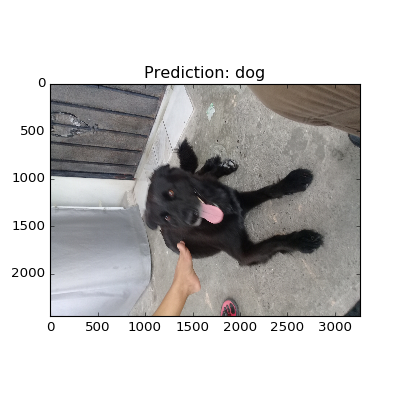

In [27]:
%matplotlib notebook

filepath = "../chap5_deep_learning_for_computer_vision/hachi.jpg"
classify_single_image(filepath)

prediction (float): 0.0902, pred_label: cat


<IPython.core.display.Javascript object>


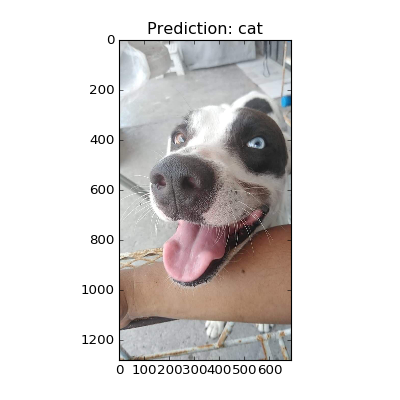

In [28]:
%matplotlib notebook

filepath = "../chap5_deep_learning_for_computer_vision/sheldon.jpg"
classify_single_image(filepath)

### Prediction 1: con generator

In [6]:
from keras.preprocessing.image import ImageDataGenerator

# aqui usamos un generator con la misma configuracion (escalamiento, modo, etc) 
# que la que usamos en el generador del training y validation
datagen_testn = ImageDataGenerator(rescale=1./255)

testn_generator = datagen_testn.flow_from_directory(
                            path_testn,
                            target_size=(150, 150),
                            batch_size=20,
                            class_mode="binary")

Found 1000 images belonging to 2 classes.


In [8]:
# load model
model = load_model("cats_and_dogs_small_1.h5")

# aqui clasificamos solo un batch
for images, true_labels in testn_generator:
    
    pred = model.predict(images)
    pred_labels = (pred > 0.5).astype('float').flatten()
    print(pred_labels)
    print(true_labels)
    
    break
    
# todo: como usar un generador para clasificar todas las imagenes del set de test?
# creo que debemos usar shuffle=False para que lea las imagenes en orden
# y debemos comparar el resultado con model.evaluate(generator)

[1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.]
[1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1.]


In [52]:
type(labels)

numpy.ndarray

In [55]:
testn_generator.samples

1000

In [37]:
# 1. vamos a clasificar TODO el test set usando un generador y calcular el acc manualmente
# Este codigo usa un loop para cargar cada batch y clasificar cada batch
# A medida que el modelo hace las predicciones, las etiquetas predichas se guardan en un arreglo
# Al final, se devuelve el arreglo
# Esta es la version larga para calcular el accuracy manualmente
from keras.preprocessing.image import ImageDataGenerator

# aqui usamos un generator con la misma configuracion (escalamiento, modo, etc) 
# que la que usamos en el generador del training y validation
datagen_testn = ImageDataGenerator(rescale=1./255)


batch_size = 20
testn_generator = datagen_testn.flow_from_directory(
                            path_testn,
                            target_size=(150, 150),
                            shuffle=False,                  # importante! para no revolver las imagenes
                            batch_size=batch_size,          # step = 1000 imagenes / 20 batch_size     
                            class_mode="binary")


n_images = testn_generator.samples
model = load_model("cats_and_dogs_small_1.h5")
steps = int(np.floor(n_images / batch_size))      # checar si es floor
all_pred_labels = np.zeros(n_images)
all_real_labels = np.zeros(n_images)

for i in range(steps):

    for images, true_labels in testn_generator:

        pred = model.predict(images)
        pred_labels = (pred > 0.5).astype('float').flatten()

        # save predictions and real labels
        all_pred_labels[i*batch_size:(i+1)*batch_size] = pred_labels
        all_real_labels[i*batch_size:(i+1)*batch_size] = true_labels

        print("batch %d/%d" % (i+1, steps))
        break

Found 1000 images belonging to 2 classes.
batch 1/50
batch 2/50
batch 3/50
batch 4/50
batch 5/50
batch 6/50
batch 7/50
batch 8/50
batch 9/50
batch 10/50
batch 11/50
batch 12/50
batch 13/50
batch 14/50
batch 15/50
batch 16/50
batch 17/50
batch 18/50
batch 19/50
batch 20/50
batch 21/50
batch 22/50
batch 23/50
batch 24/50
batch 25/50
batch 26/50
batch 27/50
batch 28/50
batch 29/50
batch 30/50
batch 31/50
batch 32/50
batch 33/50
batch 34/50
batch 35/50
batch 36/50
batch 37/50
batch 38/50
batch 39/50
batch 40/50
batch 41/50
batch 42/50
batch 43/50
batch 44/50
batch 45/50
batch 46/50
batch 47/50
batch 48/50
batch 49/50
batch 50/50


In [26]:
print("real", all_real_labels[:100])
print("pred", all_pred_labels[:100])

real [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
pred [0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [29]:
print("real", all_real_labels[:100])
print("pred", all_pred_labels[:100])

real [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
pred [0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [41]:
# ahora, calculemos el accuracy
acc = (all_pred_labels == all_real_labels).sum() / len(all_pred_labels)
print("%.15f" % acc)

# continua con 
# https://stackoverflow.com/questions/45806669/keras-how-to-use-predict-generator-with-imagedatagenerator

0.737000000000000


In [51]:
# 2. Vamos a clasificar TODO el test set usando un generador, la funcion predict_generator y calcular el acc manualmente
# A diferencia del ejemplo anterior
from keras.preprocessing.image import ImageDataGenerator

# aqui usamos un generator con la misma configuracion (escalamiento, modo, etc) 
# que la que usamos en el generador del training y validation
datagen_testn = ImageDataGenerator(rescale=1./255)

batch_size = 20
testn_generator = datagen_testn.flow_from_directory(
                            path_testn,
                            target_size=(150, 150),
                            shuffle=False,                  # importante! para no revolver las imagenes
                            batch_size=batch_size,          # step = 1000 imagenes / 20 batch_size     
                            class_mode="binary")

n_images = testn_generator.samples
model = load_model("cats_and_dogs_small_1.h5")
steps = int(np.floor(n_images / batch_size))                # checar si es floor
all_pred_labels = np.zeros(n_images)
all_real_labels = np.zeros(n_images)

# quitamos este loop
"""
for i in range(steps):

    for images, true_labels in testn_generator:

        pred = model.predict(images)
        pred_labels = (pred > 0.5).astype('float').flatten()

        # save predictions and real labels
        all_pred_labels[i*batch_size:(i+1)*batch_size] = pred_labels
        all_real_labels[i*batch_size:(i+1)*batch_size] = true_labels

        print("batch %d/%d" % (i+1, steps))
        break
"""

pred = model.predict_generator(testn_generator, steps)   # con esto tengo las predicciones, pero no tengo los labels (falta hacer el casting)
all_pred_labels = (pred > 0.5).astype('float').flatten()
all_real_labels = testn_generator.labels

# ahora, calculemos el accuracy
acc = (all_pred_labels == all_real_labels).sum() / len(all_pred_labels)
print("Acc %.15f" % acc)

Found 1000 images belonging to 2 classes.
Acc 0.737000000000000


In [52]:
# ahora, calculemos el accuracy
acc = (all_pred_labels == all_real_labels).sum() / len(all_pred_labels)
print("Acc %.15f" % acc)

Acc 0.737000000000000


In [35]:
test_acc

0.7369999980926514

In [42]:
# 3. Vamos a usar model.evaluate_generator() para calcular el accuracy
# Para que esto funcione, el modelo debe tener metrics=['acc']
from keras.preprocessing.image import ImageDataGenerator

# aqui usamos un generator con la misma configuracion (escalamiento, modo, etc) 
# que la que usamos en el generador del training y validation
datagen_testn = ImageDataGenerator(rescale=1./255)

batch_size = 20
testn_generator = datagen_testn.flow_from_directory(
                            path_testn,
                            target_size=(150, 150),
                            shuffle=False,                  # importante! para no revolver las imagenes
                            batch_size=batch_size,          # step = 1000 imagenes / 20 batch_size     
                            class_mode="binary")

n_images = testn_generator.samples
model = load_model("cats_and_dogs_small_1.h5")
steps = int(np.floor(n_images / batch_size))                # checar si es floor

# con esto calculo el accuracy usando el generator
test_loss, test_acc = model.evaluate_generator(testn_generator, steps)  # chollet, p. 158 

Found 1000 images belonging to 2 classes.


In [43]:
print("loss", test_loss)
print("acc", test_acc)     # ojo: el acc que obtuve aqui no es el mismo que el que obtuve manualmente! es muy similar pero no identico

loss 0.9966119004786015
acc 0.7369999980926514


In [ ]:
# 1. vamos a clasificar TODO el test set usando un generador y calcular el acc manualmente
from keras.preprocessing.image import ImageDataGenerator

# aqui usamos un generator con la misma configuracion (escalamiento, modo, etc) 
# que la que usamos en el generador del training y validation
datagen_testn = ImageDataGenerator(rescale=1./255)


batch_size = 20
testn_generator = datagen_testn.flow_from_directory(
                            path_testn,
                            target_size=(150, 150),
                            shuffle="false",                  # importante! para no revolver las imagenes
                            batch_size=batch_size,                    # step = 1000 imagenes / 20 batch_size     
                            class_mode="binary")


n_images = testn_generator.samples
model = load_model("cats_and_dogs_small_1.h5")
steps = int(np.floor(n_images / batch_size))      # checar si es floor
predictions = np.zeros(n_images)

for i in range(steps):

    for images, true_labels in testn_generator:

        pred = model.predict(images)
        pred_labels = (pred > 0.5).astype('float').flatten()

        # save predictions
        predictions[i*batch_size:(i+1)*batch_size] = pred_labels

        print("batch %d/%d" % (i+1, steps))
        break
    
# todo: como usar un generador para clasificar todas las imagenes del set de test?
# creo que debemos usar shuffle=False para que lea las imagenes en orden
# y debemos comparar el resultado con model.evaluate(generator)

### Predicton 2: sin generator

In [37]:
%matplotlib inline

def display_batch(batch, label="", limit=10):
    """
    Plots the images in the batch
    """
    
    for i, img in enumerate(batch):
        
        plt.figure()
        plt.imshow(img)
        title = "class: %s id: %d" % (label, i)
        plt.title(title)
        
        if (i+1) == limit:
            break

def create_batch(fnames):
    """
    Load images from a list of file paths.
    The images are preprocessed to match the shape and size expected by the model:
      - The images are rescaled in the range [0, 1]
      - The size is (150, 150)
    The output is a tensor of shape (n_samples, height, width, n_channels)
    """
    
    images = []
    
    for fname in fnames:
        
        # convert PIL to np.array (as np.float32 in the range [0, 1])
        img = image.load_img(fname,
                            color_mode="rgb",
                            target_size=(150, 150))
        x = image.img_to_array(img) * 1./255

        images.append(x)
        
    return np.array(images)
        
test_dir_cats = "/media/data/dogs_vs_cats_small/test/cats"
test_dir_dogs = "/media/data/dogs_vs_cats_small/test/dogs"

fnames_dogs = [os.path.join(test_dir_dogs, fname) for fname in os.listdir(test_dir_dogs)]
fnames_cats = [os.path.join(test_dir_cats, fname) for fname in os.listdir(test_dir_cats)]

# create the batch for dogs and cats
batch_dogs = create_batch(fnames_dogs[:32])
batch_cats = create_batch(fnames_cats[:32])

In [38]:
display_batch(batch_dogs, "dogs", limit=5)
display_batch(batch_cats, "cats", limit=5)

AttributeError: module 'matplotlib.colors' has no attribute 'to_rgba'

In [42]:
# load model
model = load_model("cats_and_dogs_small_1.h5")

# prediction
pred_dogs = model.predict(batch_dogs)
pred_cats = model.predict(batch_cats)

In [44]:
# cast to labels
pred_dogs_classes = (pred_dogs > 0.5).astype("int32").flatten()
pred_cats_classes = (pred_cats > 0.5).astype("int32").flatten()

In [45]:
pred_dogs_classes

array([1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 0], dtype=int32)